# Consensus
Consensus is support for:  
- Classification (Label IoU)
- Box (IoU)
- Polygon (IoU)
- Semantic Segmentation (IoU)
- Point (distance scoring)

## IoU

<p align="center">
  <img src="https://storage.googleapis.com/kaggle-media/competitions/rsna/IoU.jpg" width="350" title="IoU">
</p>

Some necceary imports to begin with:

In [2]:
import dtlpy as dl
from dtlpy.ml import metrics, predictions_utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Classification Consensus and Majority Vote

We'll take 5 annotators annotating the same item for example.
In order to calculate the item IoU score, we first calculate each annotator's annotation set agains all others.
But first of all, we'll use the dtlpy SDK to get all items and all annotations:

In [3]:
first_item = dl.items.get(item_id='6215d3f73750a54742c4d33d')
second_item = dl.items.get(item_id='6215d3fee2b78c63e4ae501f')
third_item = dl.items.get(item_id='6215d4053750a5fe47c4d343')
fourth_item = dl.items.get(item_id='6215d40ce2b78c3b85ae5022')
fifth_item = dl.items.get(item_id='6215d415e2b78c36b7ae5028')
first_annotations = first_item.annotations.list()
second_annotations = second_item.annotations.list()
third_annotations = third_item.annotations.list()
fourth_annotations = fourth_item.annotations.list()
fifth_annotations = fifth_item.annotations.list()

Let see which labels each annotator tagged:

In [4]:
print(f'{first_item.name} with list of anntoations: {[annotation.label for annotation in first_annotations]}')
print(f'{second_item.name} with list of anntoations: {[annotation.label for annotation in second_annotations]}')
print(f'{third_item.name} with list of anntoations: {[annotation.label for annotation in third_annotations]}')
print(f'{fourth_item.name} with list of anntoations: {[annotation.label for annotation in fourth_annotations]}')
print(f'{fifth_item.name} with list of anntoations: {[annotation.label for annotation in fifth_annotations]}')

first.png with list of anntoations: ['A', 'B']
second.png with list of anntoations: ['C', 'B']
third.png with list of anntoations: ['D', 'B', 'C']
fourth.png with list of anntoations: ['A', 'B']
fifth.png with list of anntoations: ['C']


So in order to create the annotators' scoring, we'll go over all and to the IoU calculation and save it in a list:

In [4]:
items_list = [first_item, second_item, third_item, fourth_item, fifth_item]
n_annotators = len(items_list)
items_scores = np.zeros((n_annotators, n_annotators))
for i_item in range(n_annotators):
    for j_item in range(n_annotators):
        # note: the results matrix is symmetric so calculation can be done only on one side of the diagonal
        # we do both sides to show that the score is the same: measure_itemx(x, y) == measure_itemx(y, x)
        success, results = predictions_utils.measure_item(items_list[i_item], items_list[j_item] ,ignore_labels=False)
        items_scores[i_item, j_item] = results['total_mean_score']

The returned Result object contains a pandas DataFrame with all matching and scores 

In [5]:
success, results = predictions_utils.measure_item(first_item, second_item, ignore_labels=False)
results[dl.AnnotationType.CLASSIFICATION].to_df()

,first_id,second_id,annotation_score,attribute_score,geometry_score,label_score
0,6215d4673abc0473e0fec759,None,0.0,0,0.0,0
1,6215d4673abc04e242fec75a,6215d46feb0638b474217601,1.0,1,1.0,1
2,None,6215d46feb06387f6e217602,0.0,0,0.0,0


We'll use the seaborn package to plot the metrix

<AxesSubplot:>

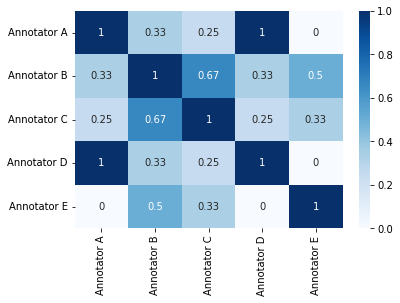

In [6]:
import seaborn as sns
sns.heatmap(items_scores, 
            annot=True, 
            cmap='Blues',
            xticklabels=['Annotator A','Annotator B','Annotator C', 'Annotator D', 'Annotator E'],
            yticklabels=['Annotator A','Annotator B','Annotator C', 'Annotator D', 'Annotator E'])

Annotator A had ['A', 'B'] and B had ['C', 'B']. The union is ['A', 'B', 'C'], intersection is only ['B'] which should give 33% match as we can see in the metrix.
Counting the appearances of each label give the fllowing:

In [7]:
# count per label
from collections import Counter
all_annotations = [first_annotations, second_annotations,third_annotations,fourth_annotations,fifth_annotations]
all_labels = [annotation.label for annotations in all_annotations for annotation in annotations]
counter = Counter(all_labels)
for label, count in counter.items():
    print('{}: {}'.format(label, count))

A: 2
B: 4
C: 3
D: 1


And if we want to output all the majority annotations (3 or more annotator gave the same label) we will get 
['B', 'C'] as the output

## Box IoU Matching

Box matching is basiclly the same. We'll get the items and annotations and "show()" the annotation of each item:

In [9]:
first_item = dl.items.get(item_id='6214bc0d3750a50f50c44841')
second_item = dl.items.get(item_id='6214be90fed92a9f043ba217')
first_annotations = first_item.annotations.list()
second_annotations = second_item.annotations.list()

[2022-02-26 14:36:26][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:36:26][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:36:27][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:36:27][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list


Text(0.5, 1.0, 'second')

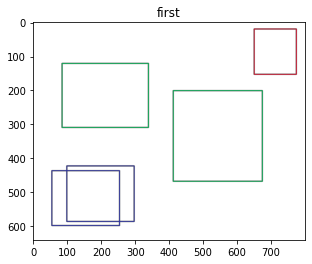

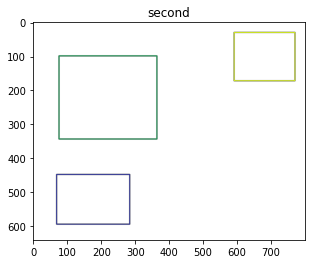

In [10]:
plt.figure()
plt.imshow(first_annotations.show())
plt.title('first')
plt.figure()
plt.imshow(second_annotations.show())
plt.title('second')

Now lets overlay the annotation on top of each other so see the matching:

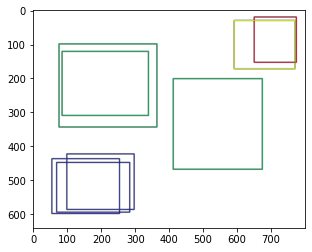

In [11]:
plt.imshow(first_annotations.show())
plt.imshow(second_annotations.show())

Running the comparison over the two items will give the results Dataframe:

In [12]:
success, results = predictions_utils.measure_item(first_item, second_item,ignore_labels=True)
results[dl.AnnotationType.BOX].to_df()

,first_id,second_id,annotation_score,attribute_score,geometry_score,label_score
0,6214c5b9f397366eeb5aacfd,6214c5c10fbf091acd473fdc,0.911934,1,0.735803,1
1,6214be3a9e37405ac057fdf7,6214bf7b5dbac533232bb903,0.893172,1,0.679517,1
2,6214c5b9f397367cd15aacfe,6214c5c10fbf090c42473fdb,0.513958,1,0.541873,0
3,6214be3a9e3740c0fc57fdf8,None,0.000000,0,0.000000,0
4,6214cef9b0f2b17df914fdba,None,0.000000,0,0.000000,0


We used the "ignore_labels=True" flag so the matching ignores the label. This means the yellow and the red anntoations at the top right are a match. If we will run the same functino without the flag we will get the following:

In [13]:
success, results = predictions_utils.measure_item(first_item, second_item, ignore_labels=False)
results[dl.AnnotationType.BOX].to_df()

,first_id,second_id,annotation_score,attribute_score,geometry_score,label_score
0,6214be3a9e37405ac057fdf7,6214bf7b5dbac533232bb903,0.893172,1,0.679517,1
1,6214be3a9e3740c0fc57fdf8,None,0.000000,0,0.000000,0
2,6214c5b9f397366eeb5aacfd,6214c5c10fbf091acd473fdc,0.911934,1,0.735803,1
3,6214cef9b0f2b17df914fdba,None,0.000000,0,0.000000,0
4,6214c5b9f397367cd15aacfe,None,0.000000,0,0.000000,0
5,None,6214c5c10fbf090c42473fdb,0.000000,0,0.000000,0


Now we are getting only two matches (two gressn and two blues) and 3 unmatched annotations (one of the blues, red and yellow)

DEBUG: View the annotaqtion comparison matrix for each two items

In [14]:
results['box'].matches._annotations_raw_df[0]

,6214be3a9e3740c0fc57fdf8,6214be3a9e37405ac057fdf7
6214bf7b5dbac533232bb903,0.0,0.679517


List of all the matching scores and the mean over the item:

In [15]:
print(results['box'].to_df()['annotation_score'])
print(results['total_mean_score'])

0    0.893172
1    0.000000
2    0.911934
3    0.000000
4    0.000000
5    0.000000
Name: annotation_score, dtype: float64
0.3008511291756962


## Polygon and Segmentation

Save as all the above, IoU scoring for two example images and anntoations:

In [16]:
first_item = dl.items.get(item_id='6214d07599cb175c9cd73d8f')
second_item = dl.items.get(item_id='6214d07c9d80b05b8310ba9b')
first_annotations = first_item.annotations.list()
second_annotations = second_item.annotations.list()

[2022-02-26 14:36:55][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:36:55][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:36:56][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:36:56][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list


Text(0.5, 1.0, 'second')

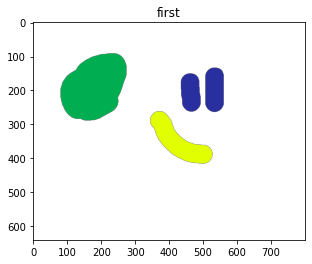

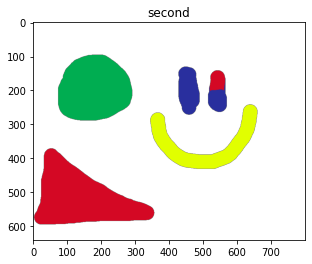

In [17]:
plt.figure()
plt.imshow(first_annotations.show())
plt.title('first')
plt.figure()
plt.imshow(second_annotations.show())
plt.title('second')

In [18]:
success, results = predictions_utils.measure_item(first_item, second_item,ignore_labels=True,match_threshold=0)
results[dl.AnnotationType.SEGMENTATION].to_df()

,first_id,second_id,annotation_score,attribute_score,geometry_score,label_score
0,6214d0e8eb06383d041eeb35,6214d103f3973620315abfe7,0.923477,1,0.770432,1
1,6214d10d32cd3ed0d196f870,6214d103f397368f135abfe8,0.840295,1,0.520886,1
2,6214d118b04184c9159549aa,6214d103f3973675265abfea,0.760693,1,0.282080,1
3,None,6214d103f3973674645abfe9,0.000000,0,0.000000,0


In [19]:
results[dl.AnnotationType.SEGMENTATION].matches._annotations_raw_df[0]

,6214d0e8eb06383d041eeb35,6214d10d32cd3ed0d196f870,6214d118b04184c9159549aa
6214d103f397368f135abfe8,0.000000,0.520886,0.00000
6214d103f3973620315abfe7,0.770432,0.000000,0.00000
6214d103f3973674645abfe9,0.000000,0.039878,0.00000
6214d103f3973675265abfea,0.000000,0.000000,0.28208


And the total score for this items is:

In [20]:
print(results['total_mean_score'])

0.6311165128941565


## Three Sets Comparison
In order to match across multiple annotators, we are calculating the scoring metrix between all couples of anntoators.
In this example we'll see 3 annotators with bounding box annotations:

In [21]:
first_item = dl.items.get(item_id='6214ea1d0ec695cd9c35dfbd')
second_item = dl.items.get(item_id='6214ea29e2b78c7ca1adc6b7')
third_item = dl.items.get(item_id='6214ea310ec695600635dfc6')
first_annotations = first_item.annotations.list()
second_annotations = second_item.annotations.list()
third_annotations = third_item.annotations.list()

[2022-02-26 14:38:00][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:38:00][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:38:01][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:38:01][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:38:03][WAR][dtlpy:v1.51.6][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-26 14:38:03][WAR][dtlpy:v1.51.6][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list


Text(0.5, 1.0, 'third')

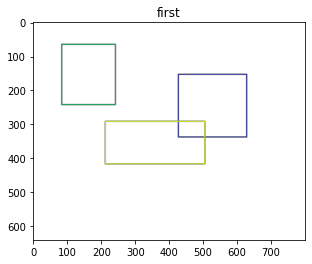

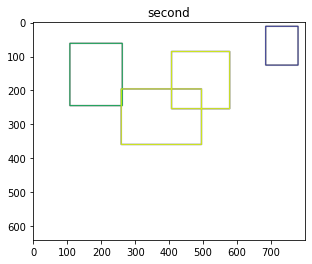

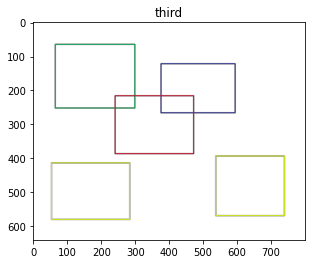

In [22]:
plt.figure()
plt.imshow(first_annotations.show())
plt.title('first')
plt.figure()
plt.imshow(second_annotations.show())
plt.title('second')
plt.figure()
plt.imshow(third_annotations.show())
plt.title('third')

Plotting all three on top of each other with different thickness to differ:

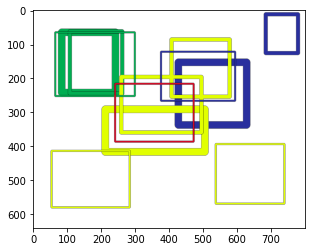

In [23]:
plt.imshow(first_annotations.show(thickness=20))
plt.imshow(second_annotations.show(thickness=10))
plt.imshow(third_annotations.show(thickness=3))

In [24]:
items = [first_item, second_item, third_item]
n_annotators = len(items)
items_scores = np.zeros((n_annotators, n_annotators))
for i_item in range(n_annotators):
    for j_item in range(i_item, n_annotators):
        success, results = predictions_utils.measure_item(items[i_item], items[j_item], ignore_labels=True)
        items_scores[i_item, j_item] = results['total_mean_score']      
        items_scores[j_item, i_item] = results['total_mean_score']

<AxesSubplot:>

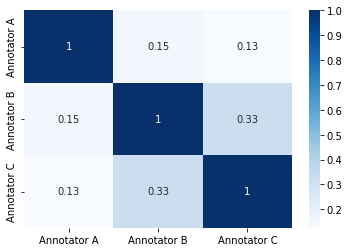

In [25]:
import seaborn as sns
sns.heatmap(items_scores, 
            annot=True, 
            cmap='Blues',
            xticklabels=['Annotator A','Annotator B','Annotator C'],
            yticklabels=['Annotator A','Annotator B','Annotator C'])